<a href="https://colab.research.google.com/github/NguyenKz/AutoCrawlCrytop/blob/main/Ollama_Setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run Ollama in Colab
---

[![5aharsh/collama](https://raw.githubusercontent.com/5aharsh/collama/main/assets/banner.png)](https://github.com/5aharsh/collama)

This is an example notebook which demonstrates how to run Ollama inside a Colab instance. With this you can run pretty much any small to medium sized models offerred by Ollama for free.

For the list of available models check [models being offerred by Ollama](https://ollama.com/library).


## Before you proceed
---

Since by default the runtime type of Colab instance is CPU based, in order to use LLM models make sure to change your runtime type to T4 GPU (or better if you're a paid Colab user). This can be done by going to **Runtime > Change runtime type**.

While running your script be mindful of the resources you're using. This can be tracked at **Runtime > View resources**.

## Running the notebook
---

After configuring the runtime just run it with **Runtime > Run all**. And you can start tinkering around. This example uses [Llama 3.2](https://ollama.com/library/llama3.2) to generate a response from a prompted question using [LangChain Ollama Integration](https://python.langchain.com/docs/integrations/chat/ollama/).

## Installing Dependencies
---

1. `pciutils` is required by Ollama to detect the GPU type.
2. Installation of Ollama in the runtime instance will be taken care by `curl -fsSL https://ollama.com/install.sh | sh`




In [1]:
!sudo apt update
!sudo apt install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,519 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/p

## Running Ollama
---

In order to use Ollama it needs to run as a service in background parallel to your scripts. Becasue Jupyter Notebooks is built to run code blocks in sequence this make it difficult to run two blocks at the same time. As a workaround we will create a service using subprocess in Python so it doesn't block any cell from running.

Service can be started by command `ollama serve`.

`time.sleep(5)` adds some delay to get the Ollama service up before downloading the model.

In [78]:
import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)

## Pulling Model
---

Download the LLM model using `ollama pull llama3.2`.

For other models check https://ollama.com/library

In [6]:
!ollama pull deepseek-ocr:3b

## And that's it!
---

With this you should be able to freely play around with the models in your scripts. Following is an example using `langchain-ollama` to answer a simple prompt.

If you have a use-case that can help out others feel free to add your notebook to [Collama](https://github.com/5aharsh/collama/fork)

In [4]:
!pip install langchain-ollama

In [1]:
import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)

In [3]:
import base64
import time  # <--- Added missing import
import requests
import os
from uuid import uuid4
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from IPython.display import Markdown, display
from PIL import Image
import io
import requests
import os

def get_image_from_url(url: str) -> str:
    response = requests.get(url)
    response.raise_for_status()

    # Ensure directory exists
    save_dir = "/content/"
    if not os.path.exists(save_dir):
        save_dir = "./"

    # Set fixed filename
    image_path = os.path.join(save_dir, "input_image.jpeg")
    print(f"Saving to: {image_path}")

    # Use PIL to read the bytes and save strictly as JPEG
    image_file = io.BytesIO(response.content)
    with Image.open(image_file) as img:
        # Convert to RGB (necessary if input is PNG with transparency)
        img = img.convert('RGB')
        img.save(image_path, "JPEG")

    return image_path


Saving to: /content/input_image.jpeg


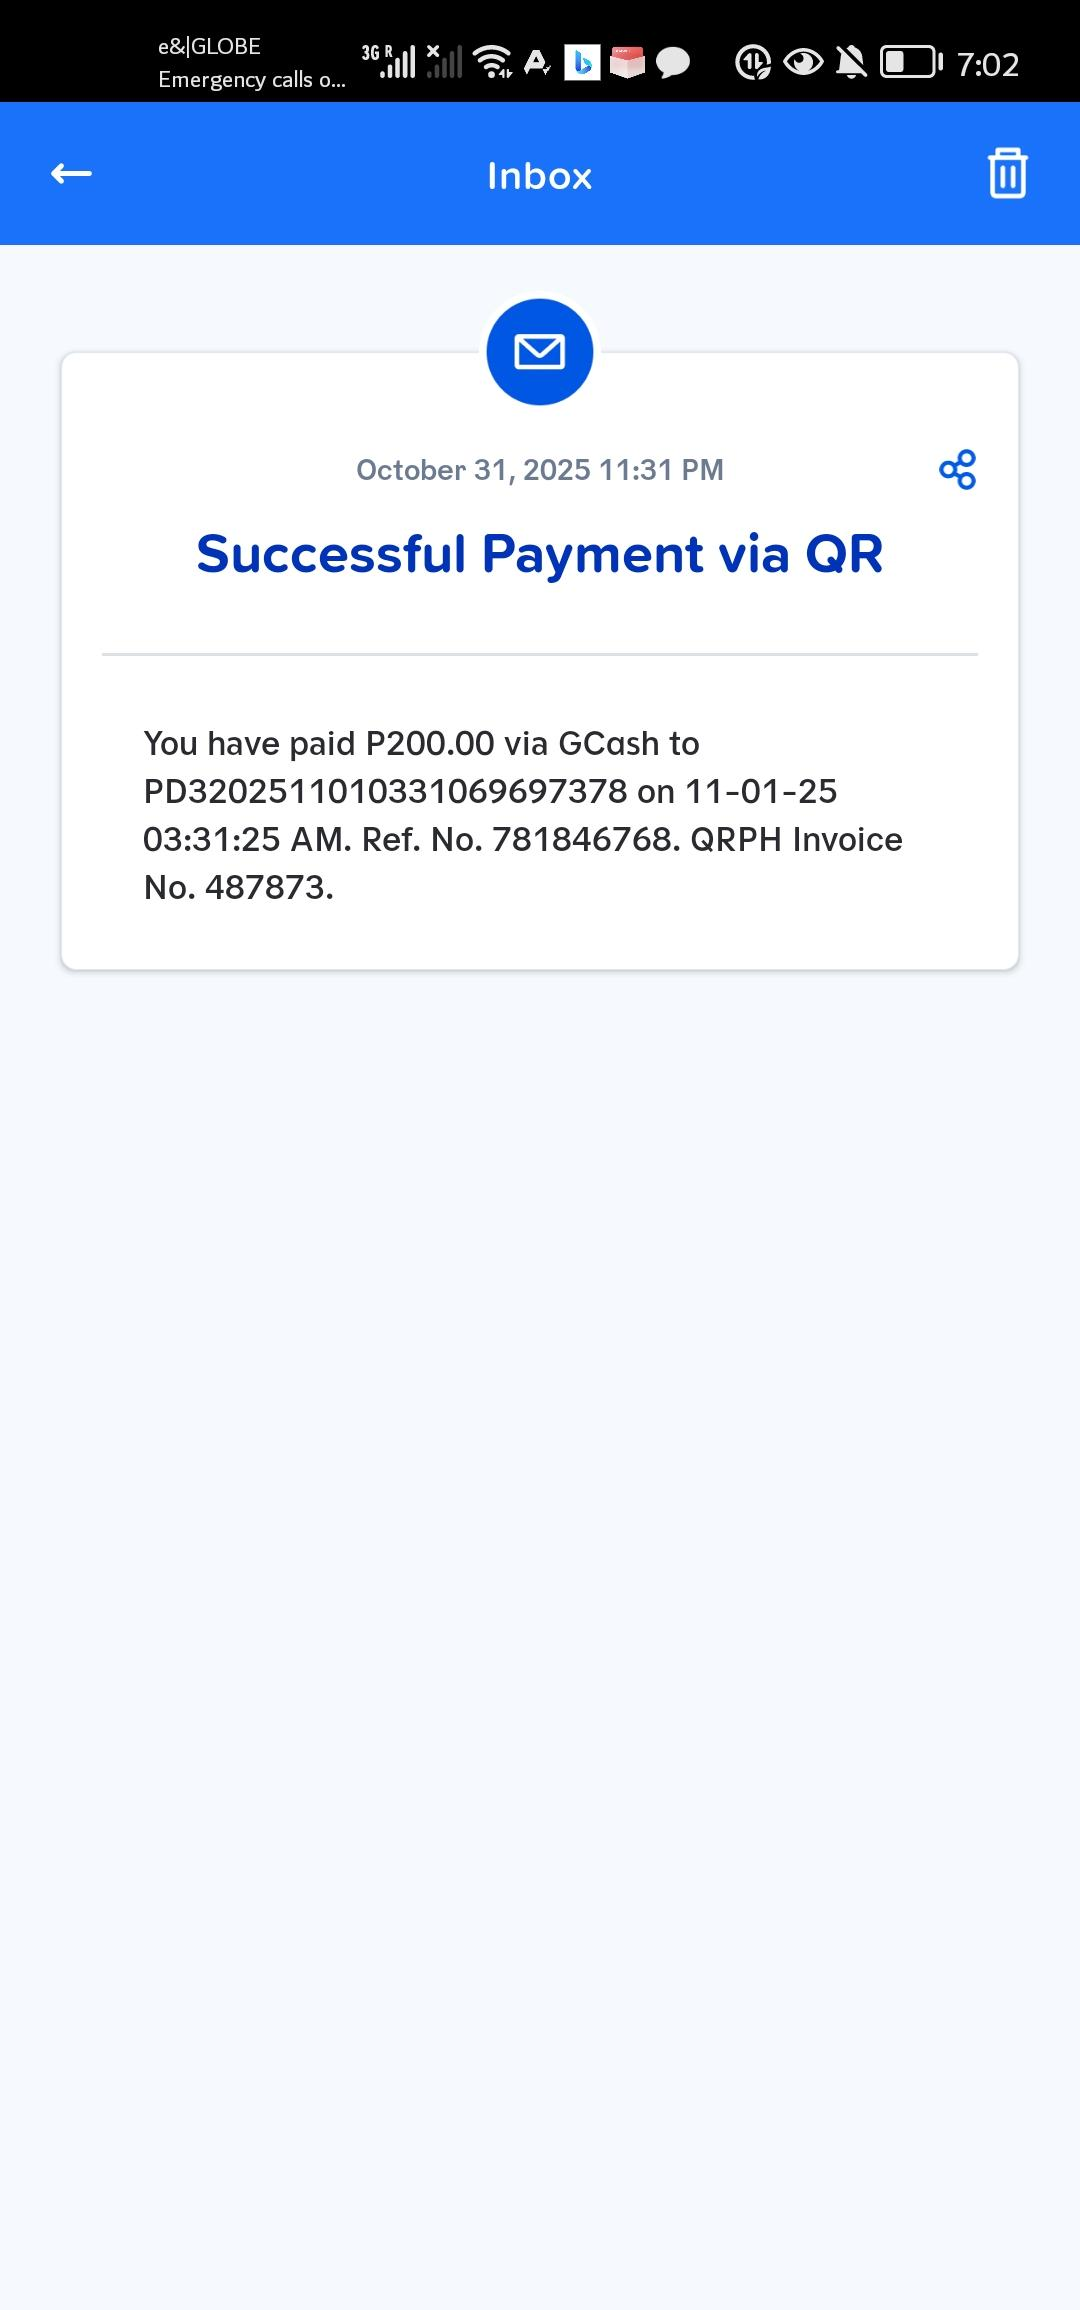

In [ ]:
import base64
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from IPython.display import Markdown

input_path = get_image_from_url("https://static.textedge.net/cs/2025/11/01/image/021018c90c35e48e3a49a43c66708537")

# 1. Define a helper function to encode the image to Base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# 2. Load your image
image_path = input_path
base64_image = encode_image(image_path)
# display image
display(Image.open(image_path))
template = """Question: <question>{question}</question>

Answer: Let's think step by step to extract all infomation of this image
*Maximum 30 words.
"""

prompt = ChatPromptTemplate.from_template(template)

model = OllamaLLM(model="deepseek-ocr:3b")

# 3. Bind the image to the model so it receives the visual data
#    (Ollama expects a list of base64 strings for the 'images' parameter)
chain = prompt | model.bind(images=[base64_image])
start_time = time.time()
# 4. Invoke the chain with a relevant prompt for OCR
response = chain.invoke({"question": """
Give me all the infomation of this image.
1. Short explaination of this image.
2. Content of this image.
"""})
display(Markdown(response))
print(f"Time taken: {round(time.time() - start_time,3)} seconds")